## REINFORCE Review

In the [previous post](% post_url 2020-07-10-reinforce %) we introduce REINFORCE, an **on-policy policy gradient algorithm**. The policy gradient theorem gives the gradient of the sum of returns for a rollout with respect to the policy parameters $\theta$:

$$
\nabla_\theta J(\theta) = \mathbb{E}_\tau \left[ \sum_{t=0}^T \nabla_\theta \log \pi_\theta (a_t \mid s_t) Q^{\pi_\theta}(s_t, a_t) \right]
$$

REINFORCE samples this gradient estimate by performing a series of $N$ **rollouts** in the environment to collect trajectories $\tau$, and then computing the **empirical returns** $G_t$ as a substitute for $Q^{\pi_\theta}(s_t, a_t)$. 
For each rollout we then compute the gradient $\nabla_\theta \log \pi_\theta(a_t \mid s_t)$ for each time step, and sum over timesteps to get an estimate for the policy gradient. We then average over rollouts to get a less noisy estimate for the gradient than a single rollout alone.

$$
\hat{g} = \frac{1}{N} \sum_{n=1}^N \sum_{t=0}^T \nabla_\theta \log \pi_\theta (a_t \mid s_t) G_t
$$

We update the policy parameters by stochastic gradient ascent (or some other gradient-based optimizer):

$$
\theta \gets \theta + \alpha \hat{g}
$$

## Baselines

One issue with using the empirical returns $G_t$ directly is that the scale of the returns can be quite large depending on the scale of the rewards, the value of $\gamma$, and the time horizon $T$ of the environment. For example, in the `CartPole-v0` problem, the time horizon is $T=200$ and the rewards are $r_t = 1$. The maximum return is then 

$$
G_0 = \sum_{t=0}^{199} 1 \gamma^t = \frac{1-\gamma^200}{1-\gamma}
$$

which for $\gamma = 0.99$ is about $181$. Returns with large scale like this can be highly variable, and as a consequence our estimates for the gradient can be highly variable. 

It turns out that we can modify the policy gradient theorem to reduce the variance!

$$
\nabla_\theta J(\theta) = \mathbb{E}_\tau \left[ \sum_{t=0}^T \log \pi_\theta(s_t \mid a_t) (Q^{\pi_\theta}(s_t, a_t) - b(s_t)) \right]
$$

we can subtract a **baseline** $b(s_t)$, which can be any function that depends on the state $s_t$.

Let's prove that the expectation of the gradient does not change:

$$
\begin{align}
\nabla_\theta J(\theta) &= \mathbb{E}_\tau \left[  \sum_{t=0}^T \nabla_\theta \log \pi_\theta (s_t, a_t)(Q^{\pi_\theta}(s_t, a_t) - b(s_t) \right] \\
&= \mathbb{E}_\tau \left[  \sum_{t=0}^T \nabla_\theta \log \pi_\theta (s_t, a_t)Q^{\pi_\theta}(s_t, a_t) \right]  -  \mathbb{E}_\tau \left[  \sum_{t=0}^T \nabla_\theta \log \pi_\theta (s_t, a_t) b(s_t) \right]
\end{align}
$$

The first term is the original policy gradient. Let's show that the second term is equal to 0. Let's define $p(s_t \mid \pi_\theta)$ to be the **visitation frequency** of $s_t$ under $pi_\theta$ (how often we expect to see $s_t$ under our policy):

$$
\begin{align}
\mathbb{E}_\tau \left[  \sum_{t=0}^T \nabla_\theta \log \pi_\theta (s_t, a_t) b(s_t) \right] &= \sum_{t=0}^T \mathbb{E}_\tau \left[\nabla_\theta \log \pi_\theta (s_t, a_t) b(s_t) \right] \\
&= \sum_{t=0}^T \sum_{s_t \in \mathcal{S}} p(s_t \mid \pi_\theta) \sum_{a_t \in \mathcal{A}} \nabla_\theta \log \pi_\theta (s_t, a_t) b(s_t) \\
&= \sum_{t=0}^T \sum_{s_t \in \mathcal{S}} p(s_t \mid \pi_\theta) b(s_t) \sum_{a_t \in \mathcal{A}} \nabla_\theta \log \pi_\theta (s_t, a_t)  \\
&= \sum_{t=0}^T \sum_{s_t \in \mathcal{S}} p(s_t \mid \pi_\theta) b(s_t) \nabla_\theta \sum_{a_t \in \mathcal{A}} \log \pi_\theta (s_t, a_t)  \\
&= \sum_{t=0}^T \sum_{s_t \in \mathcal{S}} p(s_t \mid \pi_\theta) b(s_t) \nabla_\theta 1 \\
&= \sum_{t=0}^T \sum_{s_t \in \mathcal{S}} p(s_t \mid \pi_\theta) b(s_t) 0 \\
&= 0
\end{align}
$$

This is **only true** because we can pull $b(s_t)$ through the summation over actions, so that they sum to $1$. This is why the baseline can be at most a function of the state $s_t$ (but never a function of the action $a_t$ as well, or this trick wouldn't be possible).

## Advantage function

But what function should we use as a baseline $b_t$? Consider the difference between $Q^{\pi_\theta}(s_t, a_t)$ and $V^{\pi_\theta}(s_t)$. $Q^{\pi_\theta}(s_t, a_t)$ tells us the expected return of taking an action $a_t$ in a state $s_t$, then following the policy $\pi_\theta$ for the rest of the trajectory. On the other hand, $V^{\pi_\theta}$ just tells us the expected return of beginning in a state $s_t$ and following the policy $\pi_\theta$ from this point onwards. If there is some **advantage** in choosing action $a_t$ over just following our policy, this can be captured in the difference between $Q^{\pi_\theta}(s_t, a_t)$ and $V^{\pi_\theta}(s_t)$:

$$
A^{\pi_\theta}(s_t, a_t) = Q^{\pi_\theta}(s_t, a_t) - V^{\pi_\theta}(s_t)
$$

where $A^{\pi_\theta}(s_t, a_t)$ is called the **advantage function**. If choosing $a_t$ is better than following our policy, then $A^{\pi_\theta}(s_t, a_t) > 0$. If it's worse than following our policy, then $A^{\pi_\theta}(s_t, a_t) < 0$. If $a_t$ is exactly the action suggested by our policy, then $A^{\pi_\theta}(s_t, a_t) = 0$.

If we use $V^{\pi_\theta}$ as our baseline function $b$, then the policy gradient becomes:

$$
\nabla_\theta J(\theta) = \mathbb{E}_\tau \left[ \sum_{t=0}^T \log \pi_\theta(s_t \mid a_t) A^{\pi_\theta}(s_t, a_t) \right]
$$

Using the advantage is actually incredibly intuitive. If the advantage is positive, then we increase the log probability of the action $a_t$ associated with that advantage. Likewise, if it's negative, then we decrease the log probability of the action $a_t$ associated with that advantage.

Consider `CartPole-v0` again. The rewards are always positive, so the returns are always positive. This means that the policy updates used in REINFORCE will *always* increase the log-probability of an action. It is only capable of learning because actions with high returns have their log probability increased more than actions with low returns. We never actually try to *decrease* the log-probability of any actions. By using the advantage instead, we actually decrease the log-probability of actions that perform worse than expected.

## Advantage estimation

Like $Q^{\pi_\theta}$ and $V^{\pi_\theta}$, it is extremely difficult to know the advantage exactly. Instead, we usually have to make an estimate for the advantage. There are several ways that we can do this.

### Estimating $Q^{\pi_\theta}$

In deep $Q$-learning, we use a neural network $Q_\phi$ to predict $Q^{\pi_\theta}$ for each action given the state $s_t$. We fit our network using the Bellman equation to generate targets:

$$
y_t = r_t + \gamma \max_{a_{t+1}} Q_\phi (s_{t+1}, a_{t+1})
$$

we then regress our output by minimizing the loss

$$
L(\phi) = \sum_{t=0}^T (y_t -  Q_\phi (s_t, a_t))^2
$$

Note that instead of using the Bellman equation, we could have used the empirical returns $G_t$ as the target:

$$
L(\phi) = \sum_{t=0}^T (G_t -  Q_\phi (s_t, a_t))^2
$$

The advantage of using the Bellman equation is that we can use it for continuing environments, whereas empirical returns $G_t$ are only available in episodic environments.

Deep $Q$-learning works on discrete action spaces by having one output of the neural network for each action. For continuous action spaces, this is not possible. One workaround is to simply provide both $s_t$ and $a_t$ into the network and produce a scalar output $Q_\phi(s_t, a_t)$.

### Estimating $V^{\pi_\theta}$

Just like in deep $Q$-learning, we can simply have a neural network $V_\phi$ that predicts $V^{\pi_\theta}$ given the state. We have a Bellman equation for the value function as well, which we can use to generate targets:

$$
y_t = r_t + \gamma V_\phi(s_{t+1})
$$

we then regress our output by minimizing the loss

$$
L(\phi) = \sum_{t=0}^T (y_t -  V_\phi (s_t))^2
$$

again, we could have just used the empirical returns if the environment is episodic.

$$
L(\phi) = \sum_{t=0}^T (G_t -  V_\phi (s_t))^2
$$

### Estimating $A^{\pi_\theta}$ using $Q^{\pi_\theta}$ and $V^{\pi_\theta}$

We can estimate the advantage $A^{\pi_\theta}$ by just fitting two neural networks $Q_\phi$ and $V_{\phi'}$ with parameters $\phi$ and $\phi'$. At each time step, we can take a gradient step to minimize $L(\phi)$ and $L(\phi')$ so that our estimate for the advantage improves over time. However, this method requires fitting two networks in addition to the policy network $\pi_\theta$.

When using episodic environments, it can be simpler to only fit the value network $V_\phi$, and then estimate the advantage as 

$$
\hat{A}(s_t) = G_t - V_{\phi'}(s_t)
$$

### Estimating $A^{\pi_\theta}$ using $V^{\pi_\theta}$ alone

For continuing environments, we can also get away with only fitting $V_{\phi'}$. Define the temporal-difference error or **TD error** $\delta_t^{\pi_\theta}$ to be:

$$
\delta_t^{\pi_\theta} = r_t + \gamma V^{\pi_\theta}(s_{t+1}) - V^{\pi_\theta}(s_t)
$$

This is the quantity we are minimizing when we fit $V_{\phi'}$. This quantity is actually an unbiased estimate of the advantage function:

$$
\begin{align}
\mathbb{E}_\tau \left[ \delta_t^{\pi_\theta} \mid s_t, a_t \right] &= \mathbb{E}_\tau \left[ r_t + \gamma V^{\pi_\theta}(s_{t+1}) - V^{\pi_\theta}(s_t) \mid s_t, a_t \right] \\
&= \mathbb{E}_\tau \left[ r_t + \gamma V^{\pi_\theta}(s_{t+1}) \mid s_t, a_t \right] - V^{\pi_\theta}(s_t) \\
&= Q^{\pi_\theta}(s_t, a_t) - V^{\pi_\theta}(s_t) \\
\end{align}
$$

Using our neural network $V_{\phi'}$, define

$$
\delta_t = r_t + \gamma V_{\phi'}(s_{t+1}) - V_{\phi'}(s_t)
$$

the empirical TD-error. Then we have another estimate for our advantage:

$$
\hat{A}(s_t) = \delta_t
$$

### Generalized Advantage Estimation

So far, we have seen many versions of the policy gradient theorem:

$$
g = \mathbb{E}_\tau \left[ \sum_{t=0}^T \Psi_t \nabla_\theta \log \pi_\theta (a_t \mid s_t) \right]
$$

where $\Psi_t$ is one of:

- $R_t = \sum_{k=t}^T r_k$
- $G_t = \sum_{k=t}^T \gamma^{k-t} r_k$
- $Q^{\pi_\theta}(s_t)$
- $A^{\pi_\theta}(s_t, a_t) = Q^{\pi_\theta}(s_t, a_t) - V^{\pi_\theta}(s_t)$
- $\delta_t^{\pi_\theta} = r_t + \gamma V^{\pi_\theta}(s_{t+1}) - V^{\pi_\theta}(s_t)$


We can expand the Bellman equation for the value function for $n$ time steps as follows:

$$
\begin{align}
V^{\pi_\theta}(s_t) &= \mathbb{E}_\tau \left[ G_t \mid s_t \right] \\
&= \mathbb{E}_\tau \left[ r_t + \gamma r_{t+1} + \gamma^2 r_{t+2} + \dots \mid s_t \right] \\
&= \mathbb{E}_\tau \left[ r_t + \gamma r_{t+1} + \gamma^2 r_{t+2} + \dots + \gamma^n V^{\pi_\theta}(s_{t+n}) \mid s_t \right] \\
&= \mathbb{E}_\tau \left[ \sum_{k=t}^{n-1} \gamma^{k-t} r_{k} + \gamma^n V^{\pi_\theta}(s_{t+n}) \mid s_t \right] \\
\end{align}
$$

Whereas before we only expanded it for a single time step, here we can expand it for $n$ time steps. We can then define the $n$-step TD-error as

$$
\delta_t^n = - V^{\pi_\theta}(s_t) + \sum_{k=t}^{n-1} \gamma^{k-t} r_{k} + \gamma^n V^{\pi_\theta}(s_{t+n}) 
$$

This is actually equivalent to a discounted sum of 1-step TD-errors:

$$
\begin{align}
\delta_t^n &= \sum_{i=0}^n \gamma^i \delta_{t+i} \\
&= \delta_t + \gamma \delta_{t+1} + \gamma^2 \delta_{t+2} + \dots \\
&= \quad \ \left( -V^{\pi_\theta}(s_t) + r_t + \gamma V^{\pi_\theta}(s_{t+1}) \right) \\
& \quad + \gamma \left( -V^{\pi_\theta}(s_{t+1}) + r_{t+2} + \gamma^2 V^{\pi_\theta}(s_{t+2}) \right) \\
& \quad + \gamma^2 \left( -V^{\pi_\theta}(s_{t+2}) + r_{t+3} + \gamma^3 V^{\pi_\theta}(s_{t+3}) \right) \\
& \quad + \dots \\
& \quad + \gamma^n \left( -V^{\pi_\theta}(s_{t+n-1}) + r_{t+n} + \gamma^n V^{\pi_\theta}(s_{t+n}) \right) \\
&= -V^{\pi_\theta}(s_t) + r_t + \gamma r_{t+1} + \gamma^2 r_{t+2} + \gamma^3 r_{t+3} + \dots + \gamma^n V^{\pi_\theta}(s_{t+n}) \\
&= -V^{\pi_\theta}(s_t) +\sum_{k=t}^{n-1} \gamma^{k-t} r_{k} + \gamma^n V^{\pi_\theta}(s_{t+n})
\end{align}
$$

Since in adjacent terms, the value function cancels out, leaving us with the $n$-step TD error.

Just like we can use the 1-step TD error as an advantage estimate $\hat{A}(s_t)$, we can likewise use the $n$-step TD error as an advantage estimate $\hat{A}^{(n)}(s_t)$.

Generalized advantage estimation is just an exponentially weighted average of these $n$-step estimators.

$$
\begin{align}
\hat{A}^{\text{GAE}(\gamma, \lambda)} &= (1 - \lambda) \left( \hat{A}^{(1)}(s_t) + \lambda \hat{A}^{(2)}(s_{t+1}) + \lambda^2 \hat{A}^{(3)}(s_t) + \dots \right) \\
&= (1 - \lambda) \left( \delta_t^{\pi_\theta} + \lambda \left(\delta_t^{\pi_\theta} + \gamma \delta_{t+1}^{\pi_\theta} \right) + \lambda^2 \left( \delta_t^{\pi_\theta} + \gamma \delta_{t+1}^{\pi_\theta} + \gamma^2 \delta_{t+2}^{\pi_\theta} \right) + \dots \right) \\
\end{align}
$$

Expanding and refactoring, we get

$$
\begin{align}
\frac{\hat{A}^{\text{GAE}(\gamma, \lambda)}}{1 - \lambda} &= 
 \delta_t^{\pi_\theta} \left(1 + \lambda + \lambda^2 + \dots \right) \\
& + \delta_{t+1}^{\pi_\theta} \left( \lambda + \lambda^2 + \lambda^3 + \dots \right) \\
& + \delta_{t+2}^{\pi_\theta} \left( \lambda^2 + \lambda^3 + \lambda^3 + \dots \right) + \dots 
\end{align}
$$

This is just an infinite geometric series, yielding

$$
\begin{align}
\frac{\hat{A}^{\text{GAE}(\gamma, \lambda)}}{1 - \lambda} &= \delta_t^{\pi_\theta} \left( \frac{1}{1-\lambda} \right) + \delta_{t+1}^{\pi_\theta} \left( \frac{\lambda}{1-\lambda} \right) + \delta_{t+2}^{\pi_\theta} \left( \frac{\lambda^2}{1-\lambda} \right) + \dots \\
\hat{A}^{\text{GAE}(\gamma, \lambda)} &= \sum_{i=0}^\infty (\gamma \lambda)^i \delta_{t+i}^{\pi_\theta}
\end{align}
$$

It turns out that the exponentially weighted sum has a nice and simple expression that relies only on single-step TD errors. This is good for us in terms of implementation because we can use the TD errors to fit the value network $V_{\phi'}$ and then we can reuse them the get an advantage estimate using GAE.

There are two special cases pointed out in the [original paper](https://arxiv.org/pdf/1506.02438.pdf). When $\lambda=0$, we get

$$
\hat{A}^{\text{GAE}(\gamma, 0)} = \delta_t^{\pi_\theta}
$$

when $\lambda=1$ we get

$$
\hat{A}^{\text{GAE}(\gamma, 0)} = \sum_{i=0}^\infty \gamma^i \delta_{t+i}^{\pi_\theta} = -V^{\pi_\theta}(s_t) + \sum_{i=0}^\infty \gamma^i r_{t+i} = -V^{\pi_\theta}(s_t) + G_t
$$

So $\lambda$ can let us interpolate between using the TD error as an advantage function, and using the empirical returns minus $V^{\pi)\theta}(s_t)$, both of which we covered above as possible advantage estimates. 

By using a high value of $\lambda$, we use a larger sum of terms by discounting less in the future. This gives us a less biased estimate of the advantage, but is more variable. Likewise, a low value of $\lambda$ uses a smaller sum of terms by discounting more in the future. This gives us a more biased estimate but is less variable. 

## Advantage Actor-Critic (A2C)

An **actor-critic** algorithm is a policy gradient algorithm that uses function estimation in place of empirical returns $G_t$ in the policy gradient update. The **actor** is the policy $\pi_\theta$ and the **critic** is usually a value function $V_\phi$. The actor is trained using gradient ascent on the policy gradient, and the critic is trained via regression. The regression target can either be the empirical returns $G_t$, or can be the Bellman target $r_t + \gamma V_\phi(s_t)$.

An **advantage actor-critic** is just an actor-critic that uses the **advantage** $\hat{A}(s_t)$ instead of $V^{\pi_\theta}$. Advantage can be estimated using any of the means described above.

For our purposes, we will use GAE for our advantage estimate, and fit our $V_\phi$ network using the empirical returns as the targets. We have a fixed rollout length $T$ that we use that makes every environment episodic by stopping after $T$ time steps. We can bootstrap what the "rest of the rewards" would have been by adding to the final reward $r_T$ the predicted value:

$$
r_T \gets r_T + \gamma (1-d_T) V_\phi(s_{T+1})
$$

where $d_T$ is the terminal flag for the penultimate state.

Below we use the exact same code for vectorizing our environments, as well as for our two policies. The only change to the policies is semantic in that we change the `returns` to `advantages` in the `learn` method of the policy (though from a code perspective they are the same).

In [1]:
import copy
import numpy as np
import gym

class VectorizedEnvWrapper(gym.Wrapper):
    def __init__(self, env, num_envs=1):
        '''
        env (gym.Env): to make copies of
        num_envs (int): number of copies
        '''
        super().__init__(env)
        self.num_envs = num_envs
        self.envs = [copy.deepcopy(env) for n in range(num_envs)]
    
    def reset(self):
        '''
        Return and reset each environment
        '''
        return np.asarray([env.reset() for env in self.envs])
    
    def step(self, actions):
        '''
        Take a step in the environment and return the result.
        actions (torch.tensor)
        '''
        next_states, rewards, dones = [], [], []
        for env, action in zip(self.envs, actions):
            next_state, reward, done, _ = env.step(action.item())
            if done:
                next_states.append(env.reset())
            else:
                next_states.append(next_state)
            rewards.append(reward)
            dones.append(done)
        return np.asarray(next_states), np.asarray(rewards), \
            np.asarray(dones)

In [2]:
import torch

class Policy:
    def pi(self, s_t):
        '''
        returns the probability distribution over actions 
        (torch.distributions.Distribution)
        
        s_t (np.ndarray): the current state
        '''
        raise NotImplementedError
    
    def act(self, s_t):
        '''
        s_t (np.ndarray): the current state
        Because of environment vectorization, this will produce
        E actions where E is the number of parallel environments.
        '''
        a_t = self.pi(s_t).sample()
        return a_t
    
    def learn(self, states, actions, advantages):
        '''
        states (np.ndarray): the list of states encountered during
                             rollout
        actions (np.ndarray): the list of actions encountered during
                              rollout
        advantages (np.ndarray): the list of advantages encountered during
                              rollout
        
        Because of environment vectorization, each of these has first
        two dimensions TxE where T is the number of time steps in the
        rollout and E is the number of parallel environments.
        '''
        actions = torch.tensor(actions)
        advantages = torch.tensor(advantages)

        log_prob = self.pi(states).log_prob(actions)
        loss = torch.mean(-log_prob*advantages)
        self.opt.zero_grad()
        loss.backward()
        self.opt.step()
        
        return loss

In [3]:
class DiagonalGaussianPolicy(Policy):
    def __init__(self, env, lr=1e-2):
        '''
        env (gym.Env): the environment
        lr (float): learning rate
        '''
        self.N = env.observation_space.shape[0]
        self.M = env.action_space.shape[0]
        
        self.mu = torch.nn.Sequential(
            torch.nn.Linear(self.N, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, self.M)
        ).double()

        self.log_sigma = torch.ones(self.M, dtype=torch.double, requires_grad=True)

        self.opt = torch.optim.Adam(list(self.mu.parameters()) + [self.log_sigma], lr=lr)
        
    def pi(self, s_t):
        '''
        returns the probability distribution over actions
        s_t (np.ndarray): the current state
        '''
        s_t = torch.as_tensor(s_t).double()
        mu = self.mu(s_t)
        log_sigma = self.log_sigma
        sigma = torch.exp(log_sigma)
        pi = torch.distributions.MultivariateNormal(mu, torch.diag(sigma))
        return pi

In [4]:
class CategoricalPolicy(Policy):
    def __init__(self, env, lr=1e-2):
        '''
        env (gym.Env): the environment
        lr (float): learning rate
        '''
        self.N = env.observation_space.shape[0]
        self.M = env.action_space.n
        self.p = torch.nn.Sequential(
            torch.nn.Linear(self.N, self.M),
        ).double()
        
        self.opt = torch.optim.Adam(self.p.parameters(), lr=lr)
        
    def pi(self, s_t):
        '''
        returns the probability distribution over actions
        s_t (np.ndarray): the current state
        '''
        s_t = torch.as_tensor(s_t).double()
        p = self.p(s_t)
        pi = torch.distributions.Categorical(logits=p)
        return pi

Below, we implement a `ValueEstimator` class. It is a small neural network that predicts the value function $V_\phi(s_t)$. It is fit using regression to predict the returns $G_t$.

In [17]:
class ValueEstimator:
    def __init__(self, env, lr=1e-2):
        self.N = env.observation_space.shape[0]
        self.V = torch.nn.Sequential(
            torch.nn.Linear(self.N, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 1)
        ).double()

        self.opt = torch.optim.Adam(self.V.parameters(), lr=lr)
        
    def predict(self, s_t):
        s_t = torch.tensor(s_t)
        print(s_t.shape)
        print(self.V)
        print('L', self.V(s_t))
        print(self.V(s_t).squeeze())
        print(self.V(s_t).squeeze().shape)
        return self.V(s_t).squeeze()

    def learn(self, V_pred, returns):
        returns = torch.tensor(returns)
        loss = torch.mean((V_pred - returns)**2)
        print('U', loss)
        self.opt.zero_grad()
        loss.backward()
        self.opt.step()
        
        return loss

The two functions below are similar. The `calculate_returns` function was described in an earlier post; it takes an array of rewards for each time step and computes the return for each time step by iterating backwards through the list. 

In [18]:
def calculate_returns(rewards, dones, gamma):
    result = np.empty_like(rewards)
    result[-1] = rewards[-1]
    for t in range(len(rewards)-2, -1, -1):
        result[t] = rewards[t] + gamma*(1-dones[t])*result[t+1]
    return result

The `calculate_advantages` function is essentially identical in that it computes a discounted sum, but we include it to ensure that what's going on is clear. It uses generalized advantage estimation and TD errors to compute the advantage estimate for each time step.

In [19]:
def calculate_advantages(TD_errors, lam, gamma):
    result = np.empty_like(TD_errors)
    result[-1] = TD_errors[-1]
    for t in range(len(TD_errors)-2, -1, -1):
        result[t] = TD_errors[t] + gamma*lam*result[t+1]
    return result

Finally, we can implement A2C. The implementation is quite similar to REINFORCE with a few exceptions:

1. We need to store an extra state $s_{T+1}$. This is used in two ways:
   - Since we cut off trajectories early by having a fixed rollout length $T$, we lose future rewards that we may have otherwise received. This influences the computation of the return, making it smaller than expected and potentially destroying training progress. To overcome this, we replace $r_T$ with $r_T + \gamma (1-d_T) V_\phi(s_{T+1})$. We essentially use our current estimate of the value function to boostrap what we expect the rest of the rewards to be.
   - To compute the advantage estimate for each time step $t$, we need the TD error for each time $t$ step and thus also need an estimate of the value function $V_\phi(s_{t+1})$ for the next time step. 
2. The returns are used to fit a value network, which learns to predict them.
2. Instead of using the returns in the policy gradients, we use the advantages, which are computed using the TD error provided by the value network.

One trick that researchers sometimes use to stabilize training further is to standardize the advantages for a rollout so that they have mean 0 and standard deviation 1. This ensures that advantages always fall within a certain range, and this in turn ensures that the magnitudes of the gradients stay within a certain range so that policy steps are always similar size. While this can destroy information about the relative importance of certain actions, deep reinforcement learning is notoriously unstable, so improving stability is generally worth it.

In [20]:
import seaborn as sns; sns.set()
import time

def A2C(env, agent, value_estimator, 
        gamma=0.99, lam=0.95, 
        epochs=256, train_V_iters=80, T=200
        ):    
    states = np.empty((T+1, env.num_envs, agent.N))
    if isinstance(env.action_space, gym.spaces.Discrete):
        actions = np.empty((T, env.num_envs))
    else:
        actions = np.empty((T, env.num_envs, agent.M))
    rewards = np.empty((T, env.num_envs))
    dones = np.empty((T, env.num_envs))
    
    totals = []
    
    s_t = env.reset()
    for epoch in range(epochs):
        for t in range(T):
            a_t = agent.act(s_t)
            s_t_next, r_t, d_t = env.step(a_t)
            # print(a_t)

            states[t] = s_t
            actions[t] = a_t
            rewards[t] = r_t
            dones[t] = d_t
            s_t = s_t_next
            env.envs[0].render()
            # env.envs[3].render()
            # env.envs[7].render()
        states[T] = s_t

        # bootstrap
        V_last = value_estimator.predict(states[-1]).detach().numpy() 
        rewards[-1] += gamma*(1-dones[-1])*V_last
        returns = calculate_returns(rewards, dones, gamma)
            
        for i in range(train_V_iters):
            print(np.shape(states))
            V_pred = value_estimator.predict(states)
            print('P', V_pred)
            value_estimator.learn(V_pred[:-1], returns)
        
        # compute advantages
        V_pred = V_pred.detach().numpy()
        TD_errors = rewards + gamma*(1-dones)*V_pred[1:] - V_pred[:-1]
        advantages = calculate_advantages(TD_errors, lam, gamma)
        
        # normalize advantages
        advantages = (advantages - advantages.mean())/advantages.std()
        
        pi_loss = agent.learn(states[:-1], actions, advantages)
        
        totals.append(rewards.sum()/dones.sum())
        print(f'{epoch}/{epochs}:{totals[-1]}\r', end='')
        
    sns.lineplot(x=range(len(totals)), y=totals)

In [21]:
cartpole = VectorizedEnvWrapper(gym.make("CartPole-v0"), num_envs=2)


torch.Size([2, 4])
Sequential(
  (0): Linear(in_features=4, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=1, bias=True)
)
L tensor([[0.0655],
        [0.0700]], dtype=torch.float64, grad_fn=<AddmmBackward0>)
tensor([0.0655, 0.0700], dtype=torch.float64, grad_fn=<SqueezeBackward0>)
torch.Size([2])
(201, 2, 4)
torch.Size([201, 2, 4])
Sequential(
  (0): Linear(in_features=4, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=1, bias=True)
)
L tensor([[[0.0638],
         [0.0638]],

        [[0.0622],
         [0.0552]],

        [[0.0579],
         [0.0654]],

        [[0.0607],
         [0.0632]],

        [[0.0627],
         [0.0587]],

        [[0.0609],
         [0.0614]],

        [[0.0635],
         [0.0637]],

        [[0.0484],
         [0.0499]],

        [[0.0536],
         [0.0658]],

        [[0.0494],
         [0.0627]],

        [[0.0597],
         [0.0662]],

        [[0.0552],
         [0.0505]],

   

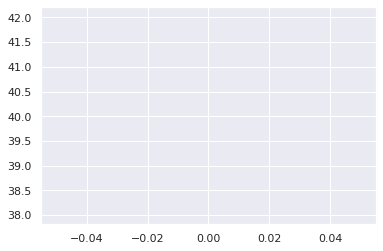

In [22]:
categorical = CategoricalPolicy(cartpole, lr=1e-1)
value_estimator = ValueEstimator(cartpole, lr=1e-2)
A2C(cartpole, categorical, value_estimator, epochs=1)

Below we run this algorithm on the `CartPoleSwingUp` environment, which as we discussed in the previous post, is a continuous environment. This environment has a much longer time horizon than `CartPole-v0`, so we increase $\gamma$ to 0.999. We also use a large value of $\lambda$ (0.99 versus 0.95 for cartpole) to get a less biased estimate of the advantage.

Hyperparameter tuning can be difficult for RL, where some algorithms' performance depends significantly on the learning rates of the policy and value networks, and on $\lambda$, $\gamma$, and even the rollout lenth $T$. To find these hyperparameters, I ran a **grid search**. To perform a grid search, create a list of potential values for each hyperparameter that you want to tune. Then, take every possible combination of these hyperparameters and run them on 5 random seeds. Look at the overall performance of each seed to pick the best set of hyperparameters. 

The usual recipe that I follow is something like:

In [ ]:
import itertools

policy_lrs = [0.1, 0.01, 0.001]
value_lrs = [0.1, 0.01, 0.001]
gammas = [0.99, 0.999]
lambdas = [0.9, 0.99]

hyperparameters = itertools.product(
                    policy_lrs,
                    value_lrs,
                    gammas,
                    lambdas)

for seed in [9827391, 8534101, 4305430, 12654329, 3483055]:
    np.random.seed(seed)
    torch.manual_seed(seed)
    for policy_lr, value_lr, gamma, lam in hyperparameters:
        pass
        # run code

Sometimes researchers will run an "initial" grid search to get a ballpark for the approximate orders of magnitude that work well with learning, then do a second grid search with a finer mesh to try to find slightly better performing hyperparameters. 

It is important to run your code many times for different random seeds. Using the same seeds can be good for reproducibility. The truth is that many deep RL algorithms are brittle, which is why authors often report [aggregate measures](https://people.cs.umass.edu/~kclary/NeurIPS_Critiquing_Trends_Workshop_2018___Variability_of_Deep_RL.pdf) of their agents, like median or mean return over time.

I ran the code below with dozens of random seeds in parallel overnight, and then plotted the learning curves of each agent. The exact same hyperparameters were used - the only change was the random seed:

![swingup.png](swingup.png)

Some agents get trapped at a local minimum around -30, which seems to be a policy that just accelerates sideways quickly to the edge of the environment to get some rewards. Some agents learn smoothly and converge around 100-200 over time. Some agents perform extremely well and end up getting up to 400 total rewards which is the environment maximum. From the paper linked above:

> An agent with poorly seeded weights, or poorly chosen random actions early in training, may find its way to a local optimum and never achieve high reward. With this context in mind, deep RL researchers often train multiple agents with different random seeds to account for this variability in training.

In [21]:
import gym_cartpole_swingup
swingup = VectorizedEnvWrapper(gym.make("CartPoleSwingUp-v0"), num_envs=8)
digauss = DiagonalGaussianPolicy(swingup, lr=1e-2)
value_estimator = ValueEstimator(swingup, lr=1e-1)
A2C(swingup, digauss, value_estimator, gamma=0.999, lam=0.99, epochs=30, T=4052)

KeyboardInterrupt: 

It seems like this particular agent is learning well, and increasing the number of learning epochs may have lead to even better performance down the road!

In the previous post, I just showed the learning curves of the two agents. I included those here as well, but I thought it would fun to record a GIF of the agent applying the learned policy in the environment. The code below runs a trained agent and produces a GIF.

In [ ]:
import imageio
from PIL import Image

def generate_gif(env, agent, filename, T=200):
    frames = []
    s_t = env.reset()
    for t in range(T):
        a_t = agent.act(s_t)
        s_t, r_t, d_t = env.step(a_t)
        frame = env.envs[0].render(mode='rgb_array')
        frames.append(frame)

    images_list = [Image.fromarray(frame) for frame in frames]
    imageio.mimsave(f'{filename}.gif', frames, duration=0.02)

In [ ]:
generate_gif(cartpole, categorical, 'cartpole')

![cartpole](cartpole.gif)

In [ ]:
generate_gif(swingup, digauss, 'swingup')

![swingup](swingup.gif)